In [29]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import seaborn
seaborn.set()


In [30]:
df = pd.read_csv("questionnaire-answers-per-clip.csv")
df

,Unnamed: 0,clipName,pptID,condition,gettingOnWell,relationshipBetweenCharacters,workingTogether,leftDominant,rightDominant,leftCooperative,...,leftFearful,rightFearful,leftSad,rightSad,leftContent,rightContent,leftAngry,rightAngry,leftAmused,rightAmused
0,0,1Laugh1PushAway,55,4,0.0,0.0,0.0,4.0,4.0,4.0,...,3.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
1,1,1Laugh1PushAway,87,4,1.0,0.0,2.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.0
2,2,1Laugh1PushAway,118,2,0.0,0.0,0.0,1.0,3.0,4.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,3.0
3,3,1Laugh1PushAway,136,2,2.0,0.0,2.0,1.0,3.0,1.0,...,2.0,1.0,2.0,2.0,1.0,1.0,1.0,3.0,2.0,2.0
4,4,1Laugh1PushAway,417,4,2.0,2.0,2.0,2.0,3.0,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,3.0,3.0,1.0
5,5,1Laugh1PushAway,681,4,1.0,1.0,2.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,4.0,2.0
6,6,1Laugh1PushAway,695,4,0.0,0.0,1.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,3.0
7,7,1Laugh1PushAway,1031,4,2.0,2.0,2.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,3.0,1.0
8,8,1Laugh1PushAway,1315,4,1.0,0.0,0.0,0.0,4.0,0.0,...,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,1.0
9,9,1Laugh1PushAway,1460,2,0.0,0.0,0.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,4.0


## PCA for dimensionality reduction

This could be improved by:
- performing a LDA on top of the PCA as well (-> to minimize intra-class - ie 'same clip' - distance while maximizing inter-class distances) (it needs to be done 'on top of the PCA' because a LDA typically requires O > 3 F with O the number of observations per class (here ~26) and F the number of features (25 questions) -> using first a PCA, F can be brought down to 5-6 for instance)
- using the results of the EFA to have a better embedding?


In [31]:
from sklearn.decomposition import PCA

In [32]:
training_df=df[df["condition"]==2] # skeleton only
training=training_df.T.iloc[4:].T.values
training_labels=training_df["clipName"].values
testing_df=df[df["condition"]==4] # full scene
testing=testing_df.T.iloc[4:].T.values
testing_labels=testing_df["clipName"].values

In [33]:
training.shape

(276, 25)

In [67]:
pca=PCA(n_components=6)
pca.fit(training)

training_pca = pca.transform(training)
testing_pca = pca.transform(testing)

## Plotting of the embeding

`plot_embedding` plots each questionnaire's response when projected along the first 2 eigenvectors. Responses' colours correspond to the clips.

In [68]:
def plot_embedding(X, labels):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        ax.plot(X[i, 0], X[i, 1], marker="o", linestyle="",label=labels[i])

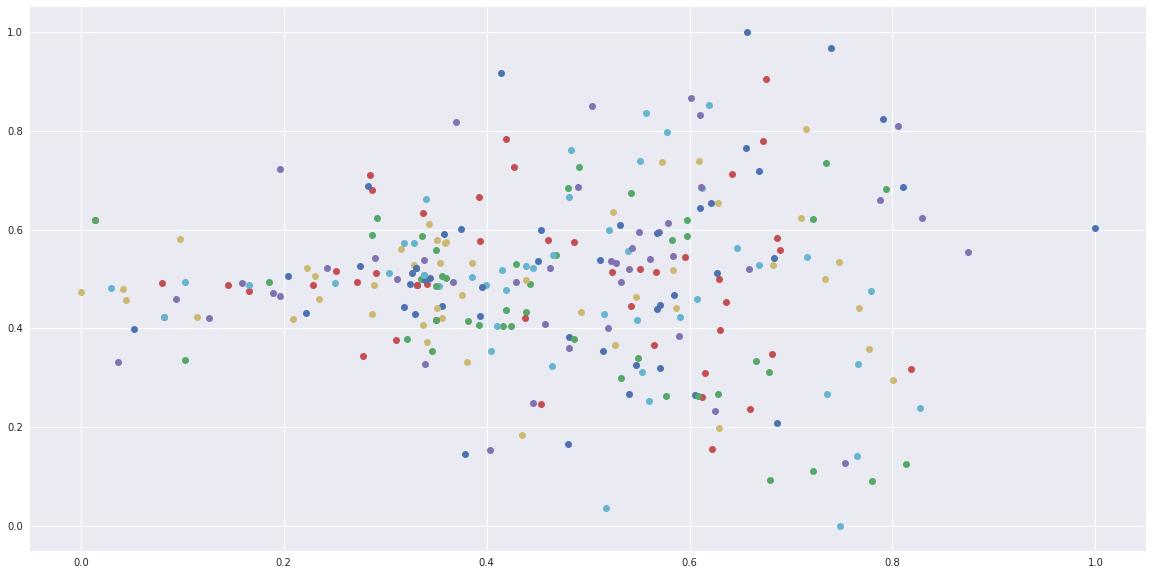

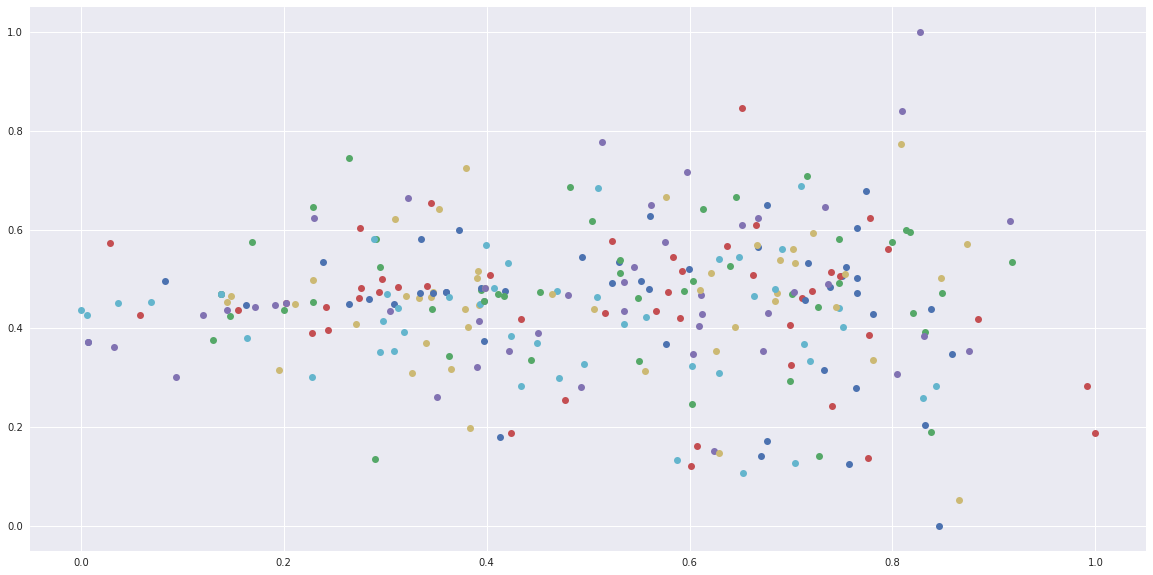

In [69]:
plot_embedding(training_pca, training_labels) 
plot_embedding(testing_pca, testing_labels)

In [70]:
pca.explained_variance_ratio_.cumsum()

array([0.28405715, 0.41658333, 0.51708521, 0.57579546, 0.62923102,
       0.67070969])

In [71]:
pca.components_


array([[ 0.17548592,  0.15016615,  0.14538466,  0.05376097,  0.13633354,
        -0.21093684, -0.2386643 ,  0.17641636,  0.23302474, -0.21699709,
        -0.25971502,  0.19025137,  0.27863681, -0.15274028, -0.11062468,
         0.20882575,  0.18131997,  0.18626668,  0.16037721, -0.23449424,
        -0.24284952,  0.2457872 ,  0.30775015, -0.14672371, -0.16033606],
       [ 0.01357949,  0.01438256,  0.02452207,  0.42994249, -0.41896846,
        -0.18209335,  0.0747369 ,  0.32136526, -0.2173944 , -0.13951877,
         0.07173952,  0.3495939 , -0.24967575,  0.0014334 , -0.1105479 ,
        -0.21517212,  0.26782144, -0.12600513,  0.1804615 ,  0.07111757,
        -0.04827713,  0.15283523, -0.13380643,  0.10641266,  0.03883441],
       [-0.14391971, -0.11048205, -0.18594399,  0.05503047,  0.2185336 ,
         0.13508949,  0.12723342,  0.30134902,  0.27324022,  0.21053698,
         0.21047521,  0.22557171,  0.28653153,  0.08431671,  0.12230118,
         0.19236272,  0.16733776,  0.12434086,  0

## LDA

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [97]:
lda = LinearDiscriminantAnalysis(n_components=4)
lda.fit(pca.transform(training), training_labels)
training_lda = lda.transform(pca.transform(training))
testing_lda = lda.transform(pca.transform(testing))

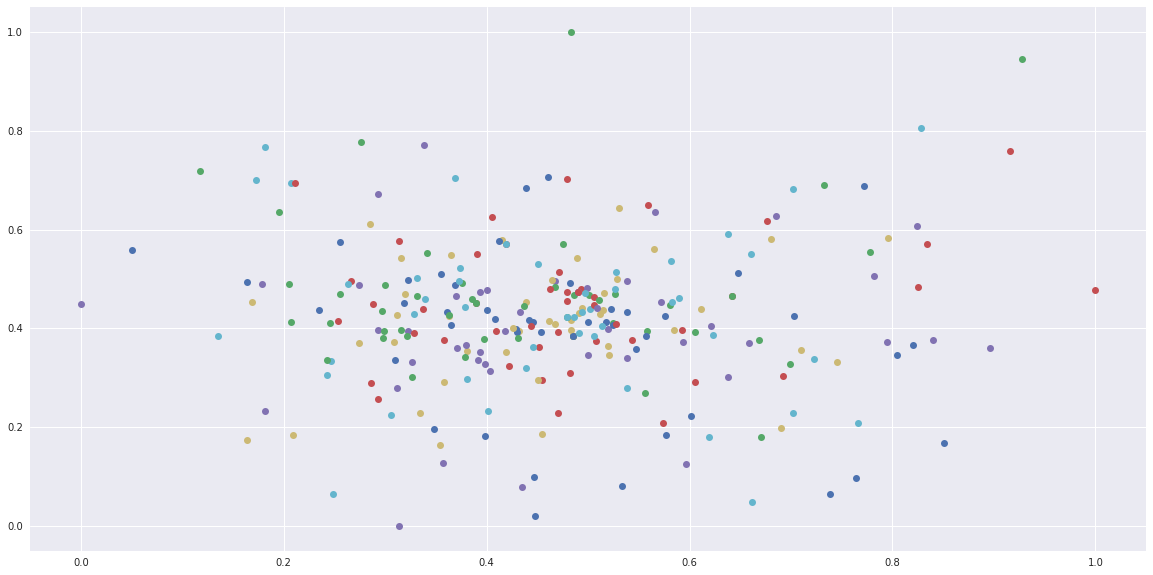

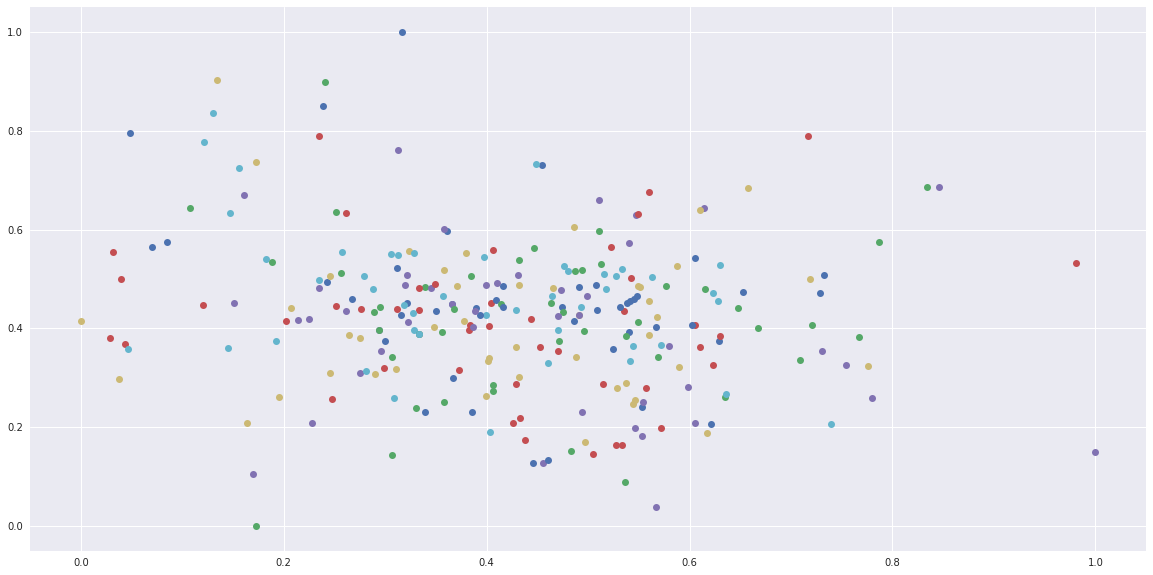

In [85]:
plot_embedding(lda.transform(pca.transform(training)), training_labels)
plot_embedding(lda.transform(pca.transform(testing)), testing_labels)

# Classification

In [86]:
from sklearn import svm

In [104]:
clf = svm.SVC(kernel='rbf')

# trying with training, training_pca, training_lda do not lead to any clear improvements
training_set = training_lda
testing_set = testing_lda

clf.fit(training_set, training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [105]:
for p, l in zip(clf.predict(testing_set), testing_labels):
    print("%s (should be %s)" % (p,l))

1PushBothExcited (should be 1Laugh1PushAway)
bothDistressedTable (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
bothDistressedTable (should be 1Laugh1PushAway)
bothDistressedTable (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
excitedChild (should be 1Laugh1PushAway)
excitedChild (should be 1Laugh1PushAway)
discussAndTogether (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
bothDistressedTable (should be 1Laugh1PushAway)
1Task1Watch (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
discussAndTogether (should be 1Laughing)
bothDistressedTable (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
discussAndTogether (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
excitedChild (should be 1Laugh

In [106]:
print("SVM: %.1f%% successful prediction out of %d tested clips" % (clf.score(testing_set, testing_labels) * 100, len(testing_labels)))

SVM: 10.1% successful prediction out of 276 tested clips


In [107]:
import itertools
def plot_confusion_matrix(cm, classes=[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


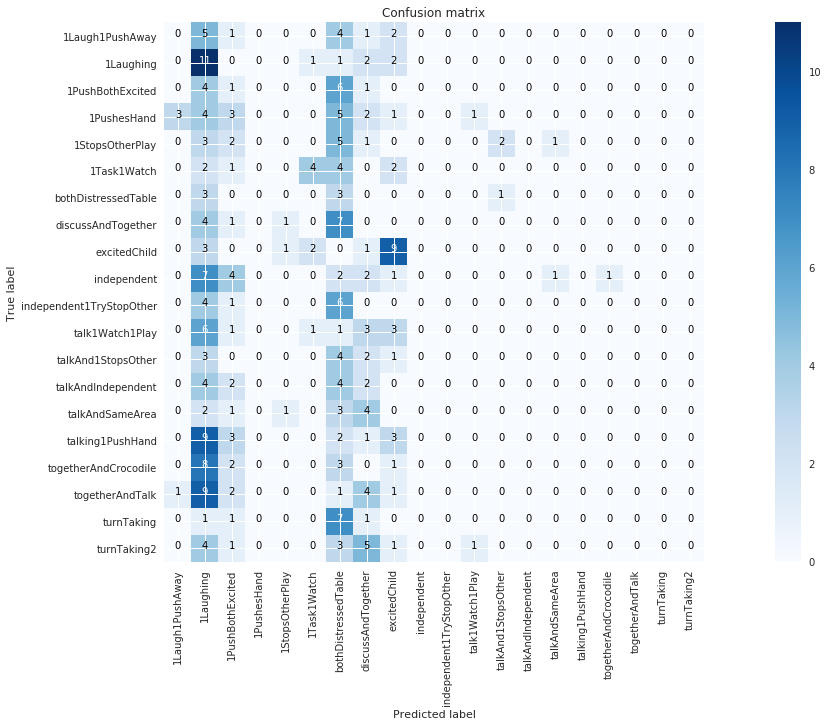

In [108]:
from sklearn.metrics import confusion_matrix
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # bigger figure!

cnf_matrix = confusion_matrix(testing_labels, clf.predict(testing_set))
plot_confusion_matrix(cnf_matrix, classes=pd.unique(testing_labels))